In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import math
from shapely.geometry import LineString, Polygon
import os

import boto3
import json

#from coordinate_transformations import normalise_column_names, transform_to_web_mercator, apply_web_mercantor

In [48]:
from secrets import access_key, secret_access_key

In [49]:
from pyproj import Transformer

def normalise_column_names(df, lat, lon):
    df.rename(columns={lat: "latitude", lon: "longitude"}, inplace = True)
    return df

def transform_to_web_mercator(row):
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
    return (transformer.transform(row.latitude, row.longitude))

def apply_web_mercantor(df):
    transformation = df.apply(transform_to_web_mercator, axis=1)
    transformation_df = transformation.apply(pd.Series)
    transformation_df.columns=['longitude_wm','latitude_wm']
    return transformation_df


### Read file from S3 

In [18]:
s3 = boto3.client('s3',
                  aws_access_key_id = access_key,
                  aws_secret_access_key = secret_access_key)

def list_not_processed_files(bucket, prefix):
    bucket = bucket
    prefix = prefix
    files = []

    for key in s3.list_objects(Bucket=bucket, Prefix = prefix)['Contents']:
        files.append(key['Key'])
    
    return files

In [20]:
bucket = 'galapagos-fishing-vessels-eu-west-1'
prefix='not_processed'

In [43]:
not_processed = list_not_processed_files(bucket, prefix)

In [45]:
for file in not_processed:
    response = s3.get_object(Bucket=bucket, Key=file)
    contentBody = response.get("Body").read().decode('utf-8')
    content_json = json.loads(contentBody)
    print(content_json)

[{'MMSI': '538003913', 'IMO': '9470959', 'SHIP_ID': '713139', 'LAT': '-1.595126', 'LON': '-93.021484', 'SPEED': '6', 'HEADING': '270', 'COURSE': '41', 'STATUS': '0', 'TIMESTAMP': '2020-10-15T12:21:44.000Z', 'DSRC': 'TER', 'UTC_SECONDS': '45', 'SHIPNAME': 'SUNNY STAR', 'SHIPTYPE': '89', 'CALLSIGN': 'V7TZ6', 'FLAG': 'MH', 'LENGTH': '184', 'WIDTH': '27.43', 'GRT': '23313', 'DWT': '37857', 'DRAUGHT': '95', 'YEAR_BUILT': '2010', 'ROT': '0', 'TYPE_NAME': 'Oil/Chemical Tanker', 'AIS_TYPE_SUMMARY': 'Tanker', 'DESTINATION': 'FOR ORDERS', 'ETA': '2020-10-14T12:00:00.000Z'}]
[{'MMSI': '538003913', 'IMO': '9470959', 'SHIP_ID': '713139', 'LAT': '-1.795126', 'LON': '-92.021484', 'SPEED': '6', 'HEADING': '315', 'COURSE': '315', 'STATUS': '0', 'TIMESTAMP': '2020-10-15T12:21:44.000Z', 'DSRC': 'TER', 'UTC_SECONDS': '45', 'SHIPNAME': 'SUNNY STAR', 'SHIPTYPE': '89', 'CALLSIGN': 'V7TZ6', 'FLAG': 'MH', 'LENGTH': '184', 'WIDTH': '27.43', 'GRT': '23313', 'DWT': '37857', 'DRAUGHT': '95', 'YEAR_BUILT': '2010', 

In [59]:
data = pd.read_json(contentBody)

Reading Json locally for now

In [50]:
data = pd.read_json("fishing_vessels_20220526_1533.json")

ValueError: Unexpected character found when decoding 'false'

### Importing map with defined coordinates

In [69]:
#Northing
LAT_max = 4.39023
LAT_min = -4.87205

#Easting
LON_max = -87
LON_min = -101

In [70]:
glpgs_img, glpgs_ext = cx.bounds2img(LON_min,
                                     LAT_min,
                                     LON_max,
                                     LAT_max,
                                     ll=True,
                                     source=cx.providers.OpenStreetMap.DE
                                    )

### Reading Marine Reserve coordinates from CSV

In [54]:
marine_reserve_coords = pd.read_csv('galapagos_marine_reserve.csv')

In [55]:
marine_reserve_coords = normalise_column_names(marine_reserve_coords, 'latitude', 'longitude')
marine_reserve_wm = apply_web_mercantor(marine_reserve_coords)

Creating Polygon

In [56]:
polygon_coords = []
for index, row in marine_reserve_wm.iterrows():
    polygon_coords.append(tuple(row))
polygon_coords.append(polygon_coords[0])

In [57]:
marine_reserve_polygon = Polygon(polygon_coords)

#### Transforming data coords

### Applying Web Mercantor Coordinate transformation

In [60]:
normalise_column_names(data, 'LAT', 'LON')

,MMSI,IMO,SHIP_ID,latitude,longitude,SPEED,HEADING,COURSE,STATUS,TIMESTAMP,...,WIDTH,GRT,DWT,DRAUGHT,YEAR_BUILT,ROT,TYPE_NAME,AIS_TYPE_SUMMARY,DESTINATION,ETA
0,538003913,9470959,713139,-1.795126,-92.021484,6,315,315,0,2020-10-15 12:21:44+00:00,...,27.43,23313,37857,95,2010,0,Oil/Chemical Tanker,Tanker,FOR ORDERS,2020-10-14T12:00:00.000Z


In [61]:
data_wm_coords = pd.concat([data, apply_web_mercantor(data)], axis = 1)

### Creating function direction-intersect function

This function checks takes the direction of the boat and draws a straight line to see if this direction intersects with the marine reserve and returns if intersection is True or False as well as a second points to draw a line

In [65]:
def direction_line(df):
    ref_angle = (df['HEADING'] + 90)%360
    dist_intersection = 500000
    dist_map = 40000
            
    angle_rad = math.radians(ref_angle)
    
    #This lat and lon are longers as its just drawing a straight line to see if intersects
    longitude_2_intersection = df['longitude_wm'] + dist_intersection * math.cos(angle_rad)
    latitude_2_intersection = df['latitude_wm'] + dist_intersection * math.sin(angle_rad)
    
    line = LineString([(df['longitude_wm'], df['latitude_wm']), (longitude_2_intersection, latitude_2_intersection)])
    intersects = line.intersects(marine_reserve_polygon)
    
    
    #This lat and lon are shorter and will be added to the DF just for plotting purposes in the map
    longitude_2_map = df['longitude_wm'] + dist_map * math.cos(angle_rad)
    latitude_2_map = df['latitude_wm'] + dist_map * math.sin(angle_rad)
    
    return (longitude_2_map, latitude_2_map, intersects)

In [66]:
second_coords = data_wm_coords.apply(direction_line, axis=1)
second_coords_wm = second_coords.apply(pd.Series)
second_coords_wm.columns=['longitude_wm_2','latitude_wm_2','intersects']

In [67]:
final_data = pd.concat([data_wm_coords, second_coords_wm], axis = 1)

#### Ploting final map

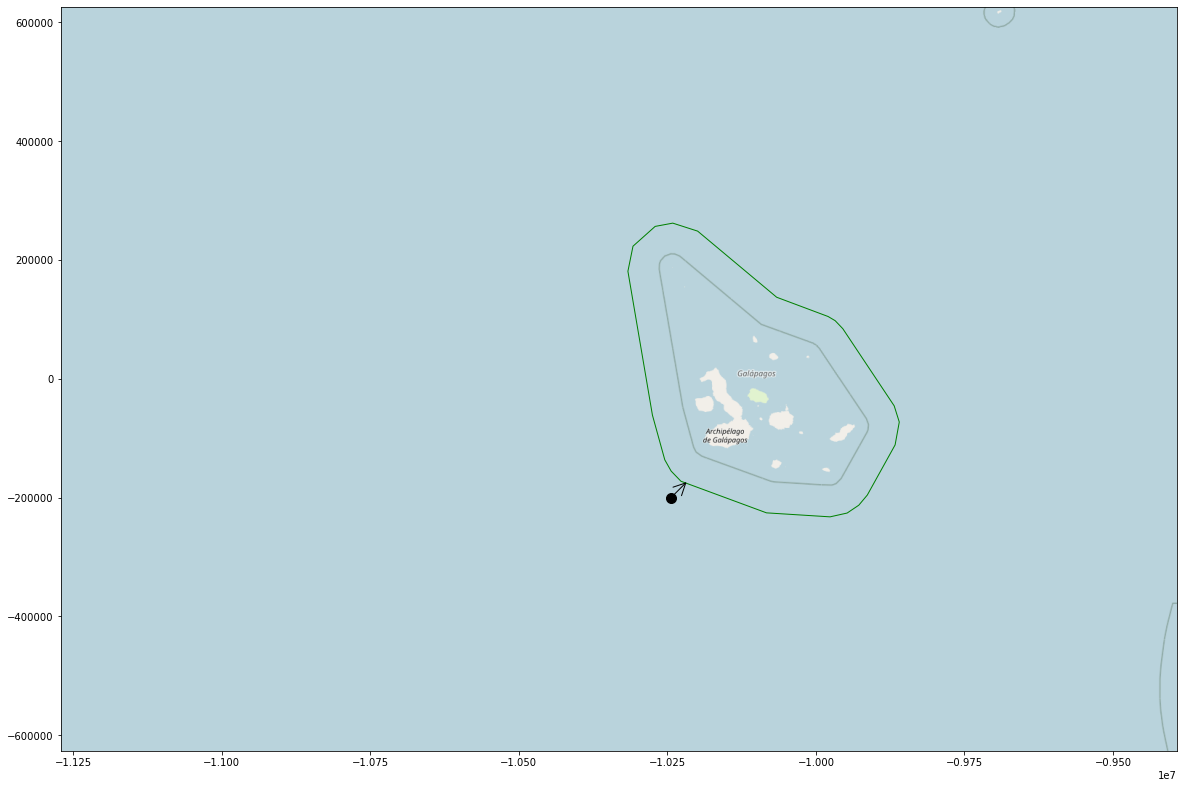

In [71]:
f, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(glpgs_img, extent=glpgs_ext)
plt.fill('longitude_wm', 'latitude_wm', data = marine_reserve_wm, edgecolor='g', fill=False)

for index, row in final_data.iterrows():
    plt.scatter(row['longitude_wm'], row['latitude_wm'], color = 'black', marker = 'o', edgecolors='black', s = 100)
    
    plt.annotate('', xytext=(row['longitude_wm'], row['latitude_wm']),\
                 xy=(row['longitude_wm_2'], row['latitude_wm_2']),\
                 arrowprops=dict(arrowstyle="->", color='black'), size = 30)
    
    plt.show()

In [16]:
final_data

,MMSI,IMO,SHIP_ID,latitude,longitude,SPEED,HEADING,COURSE,STATUS,TIMESTAMP,...,ROT,TYPE_NAME,AIS_TYPE_SUMMARY,DESTINATION,ETA,longitude_wm,latitude_wm,longitude_wm_2,latitude_wm_2,intersects
0,538003913,9470959,713139,-1.595126,-93.021484,6,45,41,0,2020-10-15 12:21:44+00:00,...,0,Oil/Chemical Tanker,Tanker,FOR ORDERS,2020-10-14T12:00:00.000Z,-1.035510e+07,-177591.556735,-1.038339e+07,-149307.285487,False
